In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Change this to cd to wherever you have the files
#ZACH:
# %cd /content/drive/My Drive/Colab Notebooks/CPSC-477/CPSC-477-Project/
#TOM and RAJA:
%cd /content/drive/My Drive/CPSC-477-Project/

/content/drive/.shortcut-targets-by-id/1ygGGGOVkhqy-8CG8UUS16DYOOWKzLRFx/CPSC-477-Project


In [ ]:
df = pd.read_csv('KBJFQC.csv')
df.head()

,Case Key,Binary,Justices,Facts,Question,Conclusion
0,2023/22-721,0,"Ketanji Brown Jackson, John G. Roberts, Jr., C...","In 2017, a Georgia jury found Damien McElrath ...",Does the Double Jeopardy Clause of the Fifth A...,The Double Jeopardy Clause of the Fifth Amendm...
1,2023/22-666,0,"Sonia Sotomayor, Elena Kagan, Neil Gorsuch, Br...","Situ Wilkinson, originally from Trinidad and T...",Is an agency determination that a given set of...,An immigration judge’s discretionary decision ...
2,2023/22-193,0,"Elena Kagan, John G. Roberts, Jr., Clarence Th...","Sergeant Muldrow, initially assigned to the In...",Does Title VII of the Civil Rights Act of 1964...,An employee challenging a job transfer under T...
3,2023/22-1178,0,"Neil Gorsuch, John G. Roberts, Jr., Clarence T...","In 2010, Yonas Fikre, a U.S. citizen of Eritre...",Are respondent’s claims challenging his placem...,The Government failed to meet its burden to de...
4,2023/22-1074,0,"Amy Coney Barrett, John G. Roberts, Jr., Clare...","The County of El Dorado, California, has a Tra...",Is a monetary exaction imposed by a local gove...,The Fifth Amendment’s Takings Clause does not ...


In [ ]:
# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_size = 'right'
tokenizer.pad_token = tokenizer.eos_token

# Make sure it's working
example_text = 'a jury found Damien McElrath'
gpt2_input = tokenizer(example_text, padding='max_length', max_length=10, truncation=True, return_tensors="pt")

print(gpt2_input['input_ids'])
print(gpt2_input['attention_mask'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tensor([[   64,  9002,  1043, 46107,  1982,  9527,    81,   776, 50256, 50256]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [ ]:
# Function to get maximum length of items in a column
def count_tokens(cell):
    if not isinstance(cell, str):
      return 0
    tokens = tokenizer(cell, padding='max_length', max_length=10, truncation=True, return_tensors="pt")
    return len(tokens['input_ids'][0])

longest_tok = 0
# Iterate through each cell using nested loops
for i in range(len(df)):  # Loop through rows
    for j in range(len(df.columns)):  # Loop through columns
        cell_value = df.iloc[i, j]  # Access cell value using iloc
        cell_len = count_tokens(cell_value)
        # print(cell_len)
        if cell_len > longest_tok:
          longest_tok = cell_len
print(longest_tok)

10


In [ ]:
print(df["num_tokens"])

0       8
1       8
2       8
3       8
4       8
       ..
2380    8
2381    8
2382    8
2383    8
2384    8
Name: num_tokens, Length: 2385, dtype: int64


In [ ]:
labels = {0:0, 1:1}
MAX_LENGTH = 1000

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['Binary']]
        input_texts = df.apply(lambda row: row["Justices"] + row['Facts'][:MAX_LENGTH-(len(row["Justices"]) + len(row["Question"]))] + row['Question'], axis=1)
        self.texts = [tokenizer(text, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt") for text in input_texts]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1908 238 239


In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)


    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

EPOCHS = 3
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=MAX_LENGTH, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

100%|██████████| 954/954 [08:43<00:00,  1.82it/s]


Epochs: 1 | Train Loss:  0.543             | Train Accuracy:  0.511             | Val Loss:  0.413             | Val Accuracy:  0.458


  4%|▍         | 39/954 [00:22<08:38,  1.77it/s]


KeyboardInterrupt: 

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

true_labels, pred_labels = evaluate(model, df_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

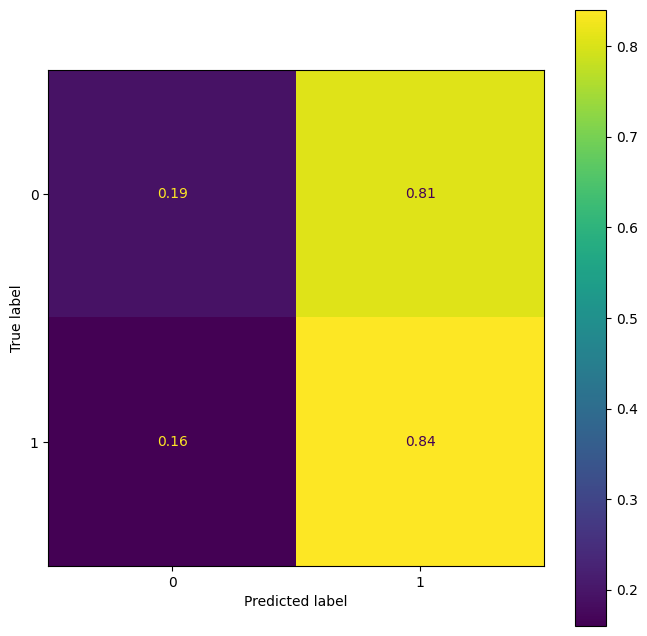

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)